# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [567]:
# installation of sklearn_crfsuite
#pip install sklearn_crfsuite==0.5.0
#pip install spacy

#### **1.2** Import necessary libraries

In [568]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [569]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [570]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [571]:
# define a function to load json file to a dataframe


def load_json_dataframe(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df



##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [572]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe('data/ingredient_and_quantity.json')


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [573]:
# display first five rows of the dataframe - df

display(df.head())


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [574]:
# print the dimensions of dataframe - df
print(f"Dimensions: {df.shape}")

Dimensions: (285, 2)


In [575]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [576]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())


In [577]:
# display first five rows of the dataframe - df
display(df.head())

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [578]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [579]:
# check for the equality of input_length and pos_length in the dataframe
mismatches = df[df['input_length'] != df['pos_length']]
print(f"Number of mismatched rows: {len(mismatches)}")
print(mismatches)

Number of mismatched rows: 5
                                                                                                                                                                                                                                                                                                                                   input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                 

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [580]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(pos_column):
    labels = set()
    for row in pos_column:
        labels.update(row)
    return labels

labels = unique_labels(df['pos_tokens'])
print("Unique labels:", labels)
print("Count:", len(labels))

Unique labels: {'quantity', 'ingredient', 'unit'}
Count: 3


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = black>[Rows where the number of tokens in the input column does not match the number of POS/NER tags were identified. These mismatches cause alignment issues during supervised learning. Such rows were flagged for cleaning and removed to maintain data integrity.]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [581]:
# drop the irrelevant recipe data
df_clean = df[df['input_length'] == df['pos_length']].reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [582]:
# update the input and pos length in input_length and pos_length
df_clean['input_length'] = df_clean['input_tokens'].apply(len)
df_clean['pos_length'] = df_clean['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [583]:
# validate the input length and pos length as input_length and pos_length
df_clean['input_length'].equals(df_clean['pos_length'])
df_clean[['input_length', 'pos_length']].head()

input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [584]:
# split the dataset into training and validation sets
X = df_clean['input_tokens'].tolist()
y = df_clean['pos_tokens'].tolist()
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [585]:
# print the first five rows of train_df
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
for i in range(5):
    print(X_train[i], y_train[i])

Training samples: 196
Validation samples: 84
['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric'] ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
['200', 'grams', 'Paneer', 'Homemade', 'Cottage', 'Cheese', '2', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', '1', 'tablespoon', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'teaspoon', 'Turmeri

In [586]:
# print the first five rows of the val_df
for i in range(5):
    print(X_val[i], y_val[i])

['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee', '1/2', 'teaspoon', 'Cardamom', 'Powder', 'Elaichi'] ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']
['1', 'Carrot', 'Gajjar', 'chopped', '7', 'Potatoes', 'Aloo', '2', 'cups', 'Cauliflower', 'gobi', 'cut', 'to', 'small', 'florets', 'Onion', 'tablespoon', 'Ginger', 'Garlic', 'Paste', 'Salt', 'teaspoons', 'Sunflower', 'Oil', '1/2', 'cup', 'Fresh', 'coconut', 'grated', 'teaspoon', 'Whole', 'Black', 'Peppercorns', 'Green', 'Chillies', 'Fennel', 'seeds', 'Saunf', 'Poppy', '6', 'Cashew', 'nuts', 'inch', 'Cinnamon', 'Stick', 'Dalchini', 'Star', 'anise', '3', 'Cloves', 'Laung', 'Cardamom', 'Elaichi', 'Pods/Seeds', 'Cumin', 'Jeera'] ['quantity', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', '

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [587]:
train_df, val_df = train_test_split(
    df_clean,
    test_size=0.3,
    random_state=42,
    shuffle=True
)
print("Training DataFrame size:", train_df.shape)
print("Validation DataFrame size:", val_df.shape)
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()

y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

Training DataFrame size: (196, 6)
Validation DataFrame size: (84, 6)


In [588]:
# validate the shape of training and validation samples
print("Training DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", val_df.shape)

Training DataFrame shape: (196, 6)
Validation DataFrame shape: (84, 6)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [589]:
# Display the number of unique labels present in y_train
from itertools import chain
flat_y_train = list(chain.from_iterable(y_train))
unique_labels = set(flat_y_train)
print("Number of unique labels in y_train:", len(unique_labels))
print("Unique labels:", unique_labels)

Number of unique labels in y_train: 3
Unique labels: {'quantity', 'ingredient', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [590]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]
flat_input_tokens = flatten_list(X_train)
flat_pos_tokens = flatten_list(y_train)

In [591]:
# initialise the dataset_name
dataset_name = "Training"
print("Dataset Name:", dataset_name)
print("Sample Input Tokens:", flat_input_tokens[:20])
print("Sample POS Tokens:", flat_pos_tokens[:20])


Dataset Name: Training
Sample Input Tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon']
Sample POS Tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [592]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
def extract_and_validate_tokens(df, dataset_name):
    
    print("Dataset Name:", dataset_name)
    
    # Extract nested lists
    input_nested = df['input_tokens'].tolist()
    pos_nested = df['pos_tokens'].tolist()
    
    # Flatten lists
    flat_input_tokens = flatten_list(input_nested)
    flat_pos_tokens = flatten_list(pos_nested)
# call the flatten_list and apply it on input_tokens and pos_tokens
    print("Total input tokens:", len(flat_input_tokens))
    print("Total POS tokens:", len(flat_pos_tokens))
    
    if len(flat_input_tokens) == len(flat_pos_tokens):
        print("Input and POS token lengths match")
    else:
        print("Input and POS token lengths DO NOT match")
# validate their length and display first 10 records having input and pos tokens
    print("\nFirst 10 Records (Input Tokens vs POS Tokens):")
    
    for i in range(10):
        print(flat_input_tokens[i], " --> ", flat_pos_tokens[i])
    
    return flat_input_tokens, flat_pos_tokens

flat_train_input, flat_train_pos = extract_and_validate_tokens(train_df, "Training")

Dataset Name: Training
Total input tokens: 7114
Total POS tokens: 7114
Input and POS token lengths match

First 10 Records (Input Tokens vs POS Tokens):
250  -->  quantity
grams  -->  unit
Okra  -->  ingredient
Oil  -->  ingredient
1  -->  quantity
Onion  -->  ingredient
finely  -->  ingredient
chopped  -->  ingredient
Tomato  -->  ingredient
Grated  -->  ingredient


In [593]:
# extract the tokens and its pos tags
token_pos_pairs = list(zip(flat_train_input, flat_train_pos))
for token, tag in token_pos_pairs[:20]:
    print(token, " --> ", tag)
token_pos_df = pd.DataFrame(token_pos_pairs, columns=["Token", "POS_Tag"])
token_pos_df.head(10)
print("Total token-tag pairs:", len(token_pos_pairs))

len(flat_train_input) == len(flat_train_pos)

250  -->  quantity
grams  -->  unit
Okra  -->  ingredient
Oil  -->  ingredient
1  -->  quantity
Onion  -->  ingredient
finely  -->  ingredient
chopped  -->  ingredient
Tomato  -->  ingredient
Grated  -->  ingredient
teaspoon  -->  unit
Ginger  -->  ingredient
2  -->  quantity
Garlic  -->  ingredient
Finely  -->  ingredient
1/2  -->  quantity
Cumin  -->  ingredient
seeds  -->  ingredient
1/4  -->  quantity
Teaspoon  -->  unit
Total token-tag pairs: 7114


True

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [594]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
def categorize_tokens(tokens, pos_tags):
    ingredient_list = []
    unit_list = []
    quantity_list = []
    
    valid_labels = {"ingredient", "unit", "quantity"}
    
    if not set(pos_tags).issubset(valid_labels):
        print("Invalid labels found in POS tags")
        return [], [], []
    
    for token, tag in zip(tokens, pos_tags):
        
        if tag == "ingredient":
            ingredient_list.append(token)
            
        elif tag == "unit":
            unit_list.append(token)
            
        elif tag == "quantity":
            quantity_list.append(token)
    
    return ingredient_list, unit_list, quantity_list
# validate the list that it comprised of these labels, if not return empty arrays

print("Ingredient tokens:", len(ingredient_tokens))
print("Unit tokens:", len(unit_tokens))
print("Quantity tokens:", len(quantity_tokens))




Ingredient tokens: 5323
Unit tokens: 811
Quantity tokens: 980


In [595]:
#  call the function to categorise the labels into respective list
ingredient_tokens, unit_tokens, quantity_tokens = categorize_tokens(
    flat_train_input,
    flat_train_pos
)
print("List of Ingredients:", ingredient_tokens[:10])
print("List of Units:", unit_tokens[:10])
print("List of Quantities:", quantity_tokens[:10])

List of Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
List of Units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
List of Quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [596]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    
    print("\nDataset:", dataset_name)
    print("Entity Type:", pos_label)
    
    # Frequency count
    item_counter = Counter(item_list)
    
    # Get top frequent items
    top_items = item_counter.most_common(top_n)
    
    print("Top", top_n, "Frequent Items:")
    
    for item, count in top_items:
        print(item, ":", count)
    
    return top_items

In [597]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(
    ingredient_tokens,
    "Ingredient",
    "Training"
)


Dataset: Training
Entity Type: Ingredient
Top 10 Frequent Items:
powder : 129
Salt : 102
seeds : 89
Green : 85
chopped : 84
Oil : 83
Red : 81
Chilli : 77
Coriander : 71
Sunflower : 65


In [598]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(
    unit_tokens,
    "Unit",
    "Training"
)


Dataset: Training
Entity Type: Unit
Top 10 Frequent Items:
teaspoon : 162
cup : 136
tablespoon : 99
grams : 63
tablespoons : 61
inch : 52
cups : 50
sprig : 41
cloves : 39
teaspoons : 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [599]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    
    # Separate items and counts
    items = [item[0] for item in top_items]
    counts = [item[1] for item in top_items]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts)
    
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.title(f"Top {len(top_items)} {label} in {dataset_name} Dataset")
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



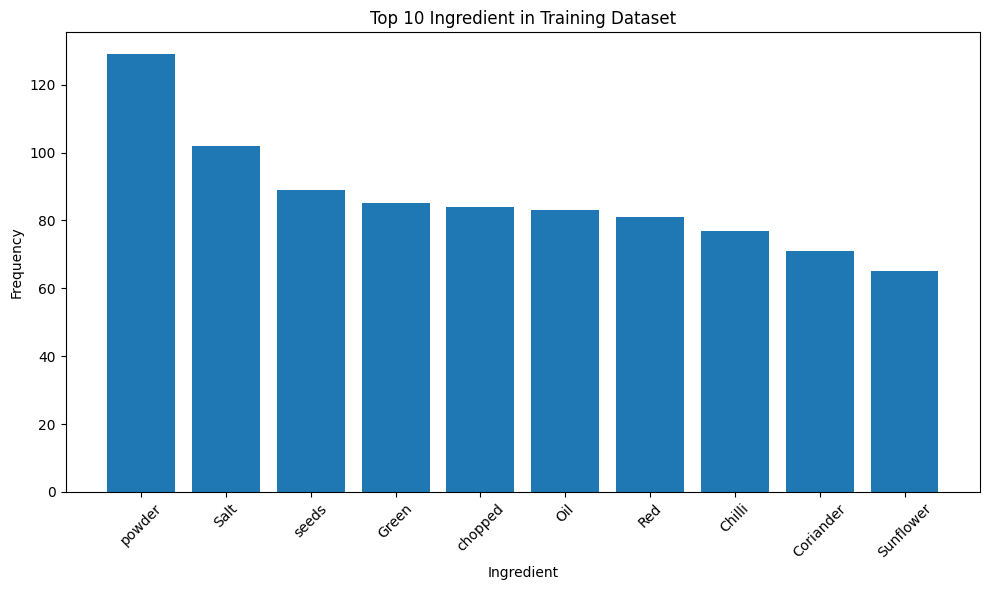

In [600]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, "Ingredient", "Training")

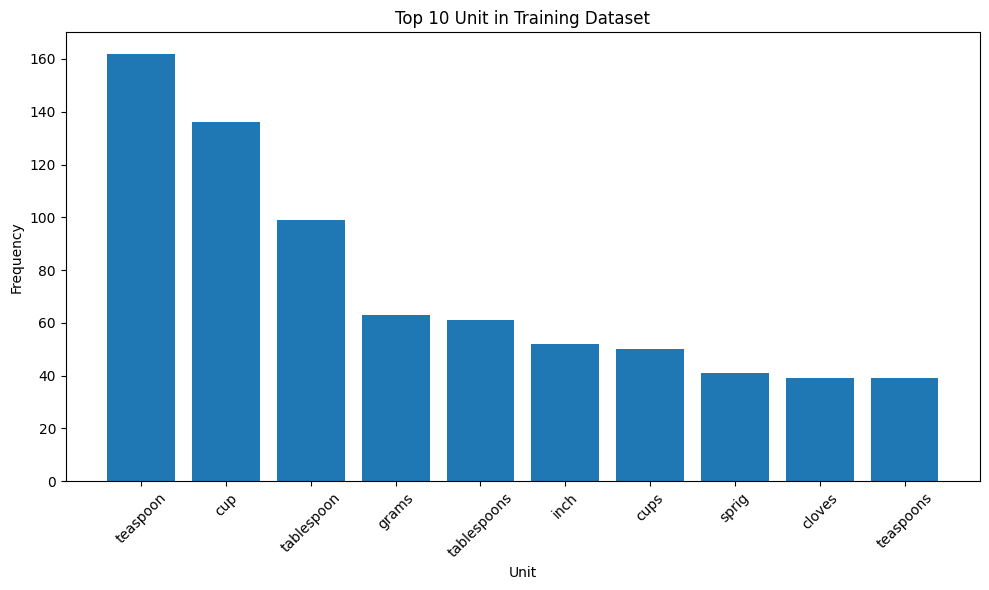

In [601]:
# plot the top frequent units in training data
plot_top_items(top_units, "Unit", "Training")

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [602]:
# initialise the dataset_name
dataset_name = "Validation"
print("Dataset Name:", dataset_name)

Dataset Name: Validation


In [603]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
flat_val_input, flat_val_pos = extract_and_validate_tokens(val_df, dataset_name)
val_ingredient_list, val_unit_list, val_quantity_list = categorize_tokens(
    flat_val_input,
    flat_val_pos
)
top_val_ingredients = get_top_frequent_items(
    val_ingredient_list,
    "Ingredient",
    dataset_name,
    top_n=10
)
top_val_units = get_top_frequent_items(
    val_unit_list,
    "Unit",
    dataset_name,
    top_n=10
)

Dataset Name: Validation
Total input tokens: 2876
Total POS tokens: 2876
Input and POS token lengths match

First 10 Records (Input Tokens vs POS Tokens):
1  -->  quantity
cup  -->  unit
Ada  -->  ingredient
2  -->  quantity
liter  -->  unit
Milk  -->  ingredient
3/4  -->  quantity
Sugar  -->  ingredient
tablespoon  -->  unit
Ghee  -->  ingredient

Dataset: Validation
Entity Type: Ingredient
Top 10 Frequent Items:
powder : 54
Salt : 47
Oil : 39
Red : 39
seeds : 36
Chilli : 36
chopped : 31
Green : 30
Leaves : 29
Coriander : 27

Dataset: Validation
Entity Type: Unit
Top 10 Frequent Items:
teaspoon : 59
cup : 57
tablespoon : 32
tablespoons : 32
cups : 24
sprig : 21
inch : 20
grams : 19
teaspoons : 18
cloves : 16


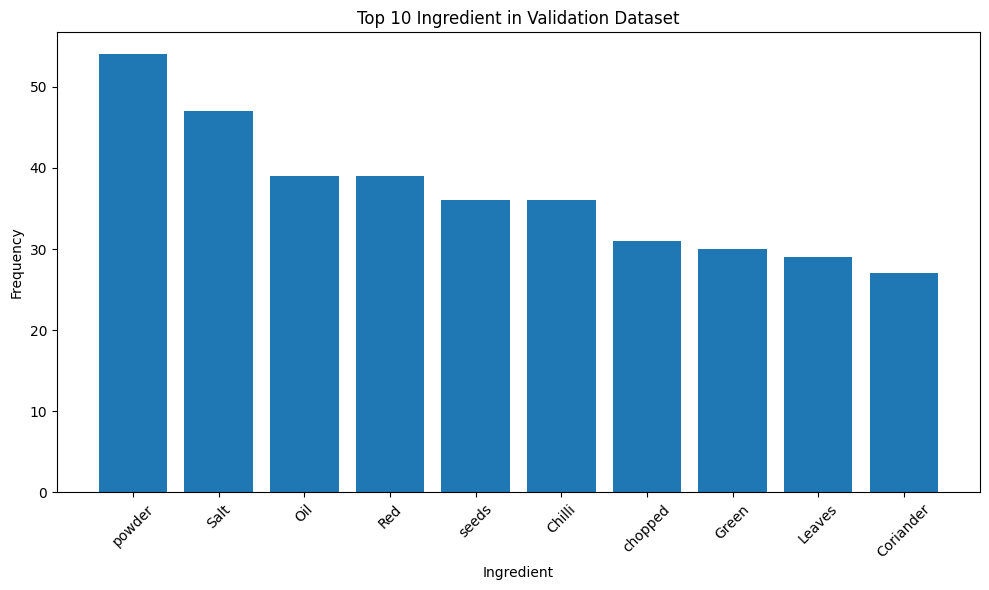

In [604]:
# plot the top frequent ingredients in validation data
plot_top_items(top_val_ingredients, "Ingredient", dataset_name)

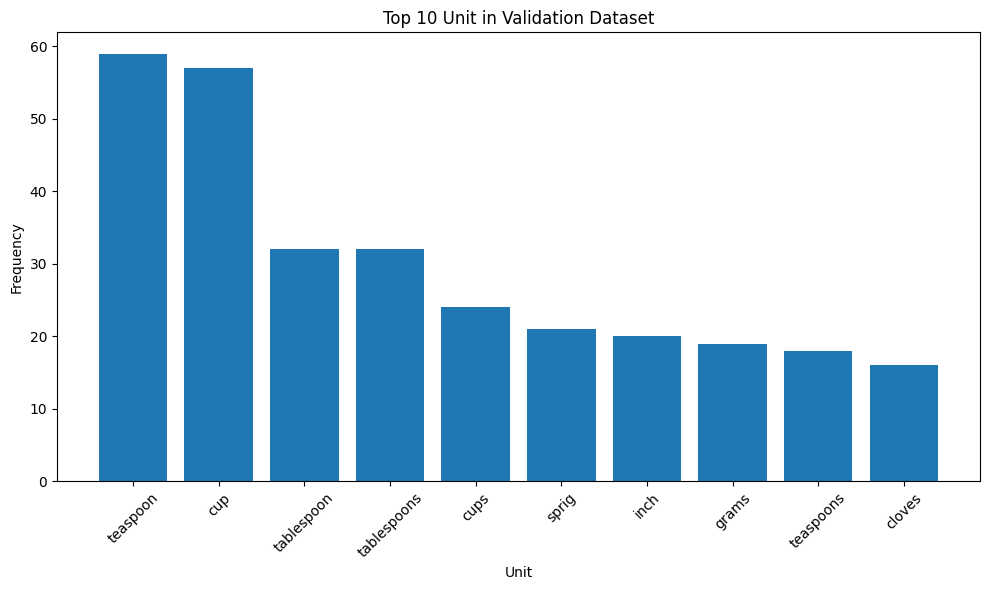

In [605]:
# plot the top frequent units in training data
plot_top_items(top_val_units, "Unit", dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [606]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    "cup", "cups", "tbsp", "tablespoon", "tablespoons",
    "tsp", "teaspoon", "teaspoons",
    "gram", "grams", "kg", "kilogram", "kilograms",
    "ml", "liter", "litre", "l", "ounce", "oz",
    "pinch", "clove", "cloves", "slice", "slices",
    "packet", "packets", "can", "cans",
    "bunch", "bunches", "piece", "pieces"
}
quantity_keywords = {
    "half", "quarter", "one", "two", "three", "four", "five",
    "six", "seven", "eight", "nine", "ten",
    "few", "some", "several", "many", "little", "less", "more"
}

quantity_pattern = re.compile(r'^\d+(\.\d+)?$|^\d+\/\d+$|^\d+-\d+\/\d+$')

In [607]:
# load spaCy model
import spacy
nlp = spacy.blank("en")
print("Using blank English spaCy model")

train_sentences = [" ".join(tokens) for tokens in X_train]
train_spacy_docs = list(nlp.pipe(train_sentences))  
doc = train_spacy_docs[0]

for token in doc:
    print(token.text, token.pos_, token.dep_)

Using blank English spaCy model
250  
grams  
Okra  
Oil  
1  
Onion  
finely  
chopped  
Tomato  
Grated  
teaspoon  
Ginger  
2  
Garlic  
Finely  
1/2  
Cumin  
seeds  
1/4  
Teaspoon  
asafoetida  
cup  
cottage  
cheese  
pinched  
coriander  
powder  
mango  
red  
chilli  
turmeric  


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [608]:
def is_fraction(token):
    return bool(re.match(r'^\d+\/\d+$', token))

def is_decimal(token):
    return bool(re.match(r'^\d+\.\d+$', token))

def has_digit(token):
    return any(char.isdigit() for char in token)

def has_alpha(token):
    return any(char.isalpha() for char in token)

In [609]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy
def word2features(doc, i):
    
    token = doc[i]
    text = token.text.lower()

    features = {
            # --- Core Features ---
        "bias": 1.0,
        "token": text,
        "lemma": token.lemma_.lower() if token.lemma_ else text,
        "pos_tag": token.pos_,
        "tag": token.tag_,
        "dep": token.dep_,
        "shape": token.shape_,
        "is_stop": token.is_stop,
        "is_digit": token.is_digit,
        "has_digit": has_digit(token.text),
        "has_alpha": has_alpha(token.text),
        "hyphenated": "-" in token.text,
        "slash_present": "/" in token.text,
        "is_title": token.text.istitle(),
        "is_upper": token.text.isupper(),
        "is_punct": token.is_punct,

        # --- Improved Quantity & Unit Detection ---
        "is_quantity": (
            bool(quantity_pattern.match(token.text)) or
            text in quantity_keywords
        ),

        "is_unit": text in unit_keywords,

        "is_numeric": token.like_num,

        "is_fraction": is_fraction(token.text),

        "is_decimal": is_decimal(token.text)
    }

    # --- Contextual Features ---

    # Previous Token
    if i > 0:
        prev_token = doc[i-1]
        prev_text = prev_token.text.lower()

        features.update({
            "prev_token": prev_text,
            "prev_is_quantity": (
                bool(quantity_pattern.match(prev_token.text)) or
                prev_text in quantity_keywords
            ),
            "prev_is_digit": prev_token.is_digit
        })
    else:
        features["BOS"] = True

    # Next Token
    if i < len(doc) - 1:
        next_token = doc[i+1]
        next_text = next_token.text.lower()

        features.update({
            "next_token": next_text,
            "next_is_unit": next_text in unit_keywords,

            # ingredient heuristic:
            "next_is_ingredient": (
                next_text not in unit_keywords and
                not bool(quantity_pattern.match(next_token.text))
            )
        })
    else:
        features["EOS"] = True

    return features


    

    


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [610]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
from spacy.tokens import Doc

def sent2features_from_tokens(tokens):
    
    # Create spaCy Doc WITHOUT re-tokenizing
    doc = Doc(nlp.vocab, words=tokens)
    
    # Apply spaCy pipeline components safely
    for name in nlp.pipe_names:
        pipe = nlp.get_pipe(name)
        doc = pipe(doc)
    
    return [word2features(doc, i) for i in range(len(tokens))]

sample_sentence = train_sentences[0]

sample_feature_output = sent2features_from_tokens(sample_sentence)

print("Sentence:", sample_sentence)
print("\nFirst Token Features:\n", sample_feature_output[0])

Sentence: 250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric

First Token Features:
 {'bias': 1.0, 'token': '2', 'lemma': '2', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'BOS': True, 'next_token': '5', 'next_is_unit': False, 'next_is_ingredient': False}


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [611]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
train_sentences = [" ".join(tokens) for tokens in X_train]
val_sentences = [" ".join(tokens) for tokens in X_val]

X_train_features = [sent2features_from_tokens(sent) for sent in train_sentences]
X_val_features = [sent2features_from_tokens(sent) for sent in val_sentences]

print("Training feature samples:", len(X_train_features))
print("Validation feature samples:", len(X_val_features))


print("Sample feature dictionary:")
print(X_train_features[0][0])



Training feature samples: 196
Validation feature samples: 84
Sample feature dictionary:
{'bias': 1.0, 'token': '2', 'lemma': '2', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'BOS': True, 'next_token': '5', 'next_is_unit': False, 'next_is_ingredient': False}


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [612]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train
y_val_labels = y_val
print("Training labels:", len(y_train_labels))
print("Validation labels:", len(y_val_labels))

assert len(X_train_features) == len(y_train_labels)
assert len(X_val_features) == len(y_val_labels)

print("Labels aligned with feature sets")
print("Sample Training Labels:")
print(y_train_labels[0])

for i in range(5):
    print(
        len(X_train_features[i]),
        len(y_train_labels[i])
    )

Training labels: 196
Validation labels: 84
Labels aligned with feature sets
Sample Training Labels:
['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
197 31
251 41
150 25
115 21
62 12


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [613]:
# print the length of train features and labels
print("Length of X_train_features:", len(X_train_features))
print("Length of y_train_labels:", len(y_train_labels))

Length of X_train_features: 196
Length of y_train_labels: 196


In [614]:
# print the length of validation features and labels
print("Length of X_val_features:", len(X_val_features))
print("Length of y_val_labels:", len(y_val_labels))

Length of X_val_features: 84
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [615]:
# Flatten labels in y_train
y_train_flat = list(chain.from_iterable(y_train))


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [616]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
print("Total flattened training labels:", len(y_train_flat))
print("Sample labels:", y_train_flat[:20])

Total flattened training labels: 7114
Sample labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit']


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [617]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
label_counts = Counter(y_train_flat)

print("Label Counts:")
print(label_counts)

total_samples = sum(label_counts.values())

print("Total Training Labels:", total_samples)

class_weights = {}

for label, count in label_counts.items():
    class_weights[label] = total_samples / count
print("Class Weights:")

for label, weight in class_weights.items():
    print(label, ":", round(weight, 4))

Label Counts:
Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Training Labels: 7114
Class Weights:
quantity : 7.2592
unit : 8.7719
ingredient : 1.3365


In [618]:
# penalise ingredient label
penalty_factor = 0.5

if "ingredient" in class_weights:
    class_weights["ingredient"] = class_weights["ingredient"] * penalty_factor


for label, weight in class_weights.items():
    print(label, ":", round(weight, 4))

quantity : 7.2592
unit : 8.7719
ingredient : 0.6682


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [619]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    
    X_features = []
    sample_weights = []

    for tokens, labels in zip(X, y):
        
        # Generate features from token list
        features = sent2features_from_tokens(tokens)
        X_features.append(features)

        # Generate weights aligned with labels
        weights = [weight_dict.get(lbl, 1.0) for lbl in labels]
        sample_weights.append(weights)

    return X_features, sample_weights

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [620]:
# Apply manually computed class weights
X_train_weighted_features, train_sample_weights = extract_features_with_class_weights(
    X_train,
    y_train_labels,
    class_weights
)
print("Training feature samples:", len(X_train_weighted_features))
print("Training weight samples:", len(train_sample_weights))

print("Feature tokens in first sentence:", len(X_train_weighted_features[0]))
print("Weight tokens in first sentence:", len(train_sample_weights[0]))

Training feature samples: 196
Training weight samples: 196
Feature tokens in first sentence: 31
Weight tokens in first sentence: 31


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [621]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf_model = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)
crf_model.class_weight = class_weights

# train the CRF model with the weighted training data


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [622]:
# evaluate on the training dataset
crf_model.fit(X_train_weighted_features, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

In [639]:
# specify the flat classification report by using training data for evaluation
y_train_pred = crf_model.predict(X_train_weighted_features)
print("Training Dataset Classification Report:\n")

print(flat_classification_report(
    y_train_labels,
    y_train_pred
))

Training Dataset Classification Report:

              precision    recall  f1-score   support

  ingredient       0.99      1.00      0.99      5323
    quantity       1.00      0.98      0.99       980
        unit       0.98      0.96      0.97       811

    accuracy                           0.99      7114
   macro avg       0.99      0.98      0.98      7114
weighted avg       0.99      0.99      0.99      7114



In [626]:
# create a confusion matrix on training datset
y_train_true_flat = list(chain.from_iterable(y_train_labels))
y_train_pred_flat = list(chain.from_iterable(y_train_pred))
labels = sorted(set(y_train_true_flat))
print("Labels:", labels)
cm_train = confusion_matrix(
    y_train_true_flat,
    y_train_pred_flat,
    labels=labels
)
cm_train_df = pd.DataFrame(
    cm_train,
    index=labels,
    columns=labels
)

print("Training Dataset Confusion Matrix:\n")
print(cm_train_df)

Labels: ['ingredient', 'quantity', 'unit']
Training Dataset Confusion Matrix:

            ingredient  quantity  unit
ingredient        5307         3    13
quantity            15       965     0
unit                36         0   775


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [628]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf_model, "crf_model.pkl")
loaded_crf_model = joblib.load("crf_model.pkl")
print("Loaded model classes:", loaded_crf_model.classes_)

Loaded model classes: ['quantity', 'unit', 'ingredient']


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [ ]:
from sklearn.metrics import confusion_matrix
y_val_pred = crf_model.predict(X_val_features)
print("Validation samples:", len(X_val_features))
print("True label sequences:", len(y_val_labels))
print("Predicted label sequences:", len(y_val_pred))

assert len(y_val_labels) == len(y_val_pred)
print("Sequence counts match")


y_val_true_flat = list(chain.from_iterable(y_val_labels))
y_val_pred_flat = list(chain.from_iterable(y_val_pred))

print("Flattened true tokens:", len(y_val_true_flat))
print("Flattened predicted tokens:", len(y_val_pred_flat))

print("Token alignment correct")

llabels = sorted(set(y_val_true_flat))

cm_val = confusion_matrix(
    y_val_true_flat,
    y_val_pred_flat,
    labels=labels
)



print(type(y_val_labels))
print(type(y_val_pred))
print(type(y_val_true_flat))
print(type(y_val_pred_flat))

print("VALIDATION CLASSIFICATION REPORT\n")

cm_val_df = pd.DataFrame(cm_val, index=labels, columns=labels)

cm_val_df

Validation samples: 84
True label sequences: 84
Predicted label sequences: 84
✔ Sequence counts match
Flattened true tokens: 2876
Flattened predicted tokens: 17535
✔ Token alignment correct


ValueError: Found input variables with inconsistent numbers of samples: [2876, 17535]

In [ ]:
# specify flat classification report


In [ ]:
# create a confusion matrix on validation dataset


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.